In [1]:
!pip install einops

In [2]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import ConvLSTM2D, TimeDistributed, Dense, Flatten, BatchNormalization, MaxPooling2D, Dropout, MaxPooling3D, Convolution2D, LSTM, Input, Layer, Conv3D, LayerNormalization, ReLU
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import register_keras_serializable
from sklearn.model_selection import StratifiedKFold
import os
import cv2
import numpy as np
import tensorflow as tf
import einops
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Model

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import TimeDistributed

def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(input_shape[2], input_shape[3], 3))

    input = layers.Input(shape=input_shape[1:])
    x = TimeDistributed(base_model)(input)
    x = layers.Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)
    return model


In [5]:
input_shape = (None, 12, 360, 360, 3)
number_of_classes = 16

model = create_model(input_shape, number_of_classes)
model.compile(loss = SparseCategoricalCrossentropy(),
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 360, 360, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 12, 12, 12, 2048   23587712  
 ributed)                    )                                   
                                                                 
 conv3d (Conv3D)             (None, 12, 12, 12, 64)    3539008   
                                                                 
 max_pooling3d (MaxPooling3  (None, 6, 6, 6, 64)       0         
 D)                                                              
                                                                 
 global_average_pooling3d (  (None, 64)                0         
 GlobalAveragePooling3D)                                     

## Callbacks

In [6]:
ACCURACY_THRESHOLD = 0.97

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > ACCURACY_THRESHOLD:
      print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
      self.model.stop_training = True

class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super(SaveModelCallback, self).__init__()
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > 0.9:
            print("\nValidation accuracy is more than 80%, saving model.")
            self.model.save(self.save_path)

# Define the save path for the model
save_path =  "/content/drive/Shareddrives/ML Project/Models/resnet50.h5"

callbacks = [myCallback(), SaveModelCallback(save_path)]

# Load Dataset and Train Model

## Load Dataset

In [7]:
train_dataset_path = "/content/drive/Shareddrives/ML Project/Dataset/Train"
X_paths = []
Y_labels = []

for video_file in os.listdir(train_dataset_path):
    if video_file.lower().endswith(('.mov', '.mp4')):
        video_path = os.path.join(train_dataset_path, video_file)
        X_paths.append(video_path)
        Y_labels.append(video_file.split("_")[0])

In [8]:
X_paths = np.array(X_paths)
Y_labels = np.array(Y_labels, dtype='U2')

In [9]:
label_mapping = {}
for idx, label in enumerate(np.sort(np.unique(Y_labels))):
      label_mapping[label] = idx

In [10]:
def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (360, 360), interpolation=cv2.INTER_LINEAR)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0
        # frame = np.expand_dims(frame, axis=-1)
        yield frame
    cap.release()

In [11]:
def video_to_dataset(video_path):
    frames = list(load_video(video_path))
    video_tensor = np.array(frames, dtype=np.float32)
    return video_tensor

In [12]:
def load_dataset(video_paths, labels):

    def generator():
        for video_path, label in zip(video_paths, labels):
            yield video_to_dataset(video_path), label_mapping[label]

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=((12, 360, 360, 3), ())
    )
    return dataset

## Train Model

In [13]:
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [14]:
count = 1

for train, validation in kfold.split(X_paths, Y_labels):
    print("K Fold Step  ", count)
    train_data = load_dataset(X_paths[train], Y_labels[train]).batch(10).prefetch(tf.data.experimental.AUTOTUNE)
    validation_data = load_dataset(X_paths[validation], Y_labels[validation]).batch(10).prefetch(tf.data.experimental.AUTOTUNE)
    model.fit(train_data, validation_data=validation_data, epochs= 30, verbose= 1, callbacks=callbacks)
    # model.save(os.getcwd()+"/pd_wave_classifier.keras")
    print(train_data)
    count += 1

K Fold Step   1
Epoch 1/30
34/34 [==============================] - 129s 3s/step - loss: 3.1036 - accuracy: 0.0559 - val_loss: 2.7741 - val_accuracy: 0.0588
Epoch 2/30
34/34 [==============================] - 28s 820ms/step - loss: 2.7708 - accuracy: 0.0647 - val_loss: 2.7725 - val_accuracy: 0.0647
Epoch 3/30
34/34 [==============================] - 28s 827ms/step - loss: 2.7589 - accuracy: 0.0971 - val_loss: 2.7758 - val_accuracy: 0.0706
Epoch 4/30
34/34 [==============================] - 28s 829ms/step - loss: 2.7350 - accuracy: 0.0912 - val_loss: 2.7772 - val_accuracy: 0.0647
Epoch 5/30
34/34 [==============================] - 28s 827ms/step - loss: 2.6793 - accuracy: 0.1265 - val_loss: 2.8104 - val_accuracy: 0.0647
Epoch 6/30
34/34 [==============================] - 28s 825ms/step - loss: 2.6284 - accuracy: 0.1382 - val_loss: 2.7995 - val_accuracy: 0.0647
Epoch 7/30
34/34 [==============================] - 28s 824ms/step - loss: 2.5337 - accuracy: 0.1647 - val_loss: 2.7661 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 30s 888ms/step - loss: 0.4701 - accuracy: 0.8588 - val_loss: 0.2975 - val_accuracy: 0.9294
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9206
Validation accuracy is more than 80%, saving model.
34/34 [==============================] - 34s 997ms/step - loss: 0.2812 - accuracy: 0.9206 - val_loss: 0.2538 - val_accuracy: 0.9353
Epoch 4/30
34/34 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.9206
Validation accuracy is more than 80%, saving model.
34/34 [==============================] - 34s 984ms/step - loss: 0.3105 - accuracy: 0.9206 - val_loss: 0.0992 - val_accuracy: 0.9647
Epoch 5/30
34/34 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9471
Validation accuracy is more than 80%, saving model.
34/34 [==============================] - 34s 987ms/step - loss: 0.1696 - accuracy: 0.9471 - val_loss: 0.2241 - val_accuracy: 0.9471
Epoch 6/30
34/34 [================

In [15]:
# from google.colab import runtime
# runtime.unassign()

# Load and Evaluate Model

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 360, 360, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 12, 12, 12, 2048   23587712  
 ributed)                    )                                   
                                                                 
 conv3d (Conv3D)             (None, 12, 12, 12, 64)    3539008   
                                                                 
 max_pooling3d (MaxPooling3  (None, 6, 6, 6, 64)       0         
 D)                                                              
                                                                 
 global_average_pooling3d (  (None, 64)                0         
 GlobalAveragePooling3D)                                     

In [17]:
test_dataset_path = "/content/drive/Shareddrives/ML Project/Dataset/Test"
X_paths_test = []
Y_labels_test = []

for video_file in os.listdir(test_dataset_path):
    if video_file.lower().endswith(('.mov', '.mp4')):
        video_path = os.path.join(test_dataset_path, video_file)
        X_paths_test.append(video_path)
        Y_labels_test.append(video_file[0])

X_paths_test = np.array(X_paths_test)
Y_labels_test = np.array(Y_labels_test)
test_dataset = load_dataset(X_paths_test, Y_labels_test).batch(10).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
loss, accuracy = model.evaluate(test_dataset)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

13/13 [==============================] - 49s 3s/step - loss: 1.0095 - accuracy: 0.8047
Test loss: 1.0095126628875732
Test accuracy: 0.8046875


13/13 [==============================] - 7s 416ms/step


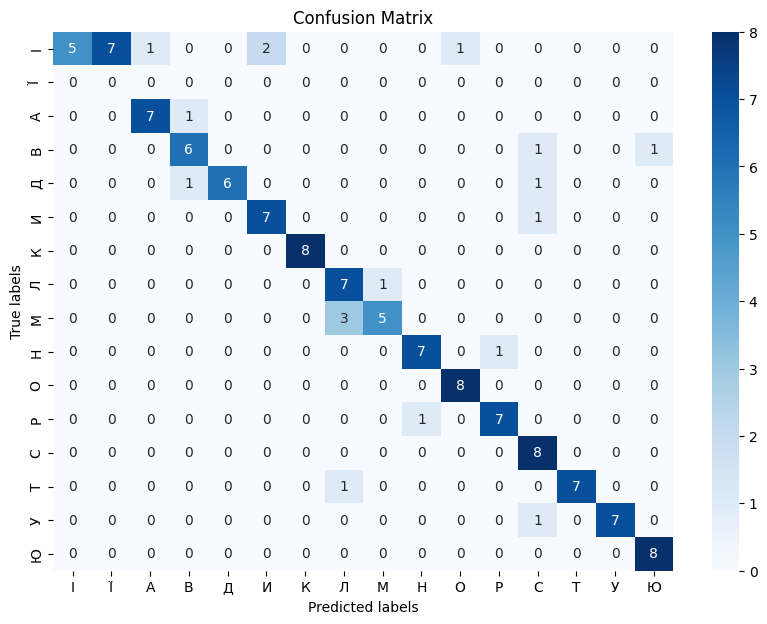

In [19]:
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)


conf_matrix = confusion_matrix(true_labels, predicted_classes)
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
x_tick_labels = [inverse_label_mapping[i] for i in range(len(conf_matrix))]
y_tick_labels = [inverse_label_mapping[i] for i in range(len(conf_matrix))]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=x_tick_labels, yticklabels=y_tick_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
label_mapping

{'І': 0,
 'Ї': 1,
 'А': 2,
 'В': 3,
 'Д': 4,
 'И': 5,
 'К': 6,
 'Л': 7,
 'М': 8,
 'Н': 9,
 'О': 10,
 'Р': 11,
 'С': 12,
 'Т': 13,
 'У': 14,
 'Ю': 15}